In [ ]:
#| default_exp examples

In [ ]:
#| include: false
from nbdev.showdoc import *

In [ ]:
#| export
import qsample as qs
import numpy as np
import matplotlib.pyplot as plt

In this section, we show more examples of quantum protocols and sampling outcomes for both direct MC and subset sampling. All examples are also described in more detail in the linked paper.

## 1. GHZ state preparation

See sections 1C and 3B in paper

In [ ]:
#| export

## 1. Repeat-until-succes GHZ-preparation (max. depth 3)

# Define quantum circuit for GHZ preparation on 4 qubits
# with a flag on 5-th qubit, signalling fault-tolerant preparation status

ghz = qs.Circuit([ {"init": {0,1,2,3,4}},
                   {"H": {0}},
                   {"CNOT": {(0,1)}},
                   {"CNOT": {(1,2)}},
                   {"CNOT": {(2,3)}},
                   {"CNOT": {(3,4)}},
                   {"CNOT": {(0,4)}},
                   {"measure": {4}}   ])

# Define protocol for 1 round of repetition

def logErr(msmt_list):
    return msmt_list[-1] == 1 # If True transition to FAIL

functions = {'logErr': logErr}

ghz1 = qs.Protocol(check_functions=functions, fault_tolerant=False)

ghz1.add_node('ghz', circuit=ghz) # Add node with corresponding circuit
ghz1.add_edge('START', 'ghz', check='True') # Transition START -> first circuit node always True
ghz1.add_edge('ghz', 'FAIL', check='logErr(ghz)') # Transition to final node FAIL if logErr(ghz) True.

--- Direct MC sampling ---


p=('1.00e-03',):   0%|          | 0/10000 [00:00<?, ?it/s]

p=('5.62e-03',):   0%|          | 0/10000 [00:00<?, ?it/s]

p=('3.16e-02',):   0%|          | 0/10000 [00:00<?, ?it/s]

p=('1.78e-01',):   0%|          | 0/10000 [00:00<?, ?it/s]

p=('1.00e+00',):   0%|          | 0/10000 [00:00<?, ?it/s]

--- Subset sampling ---


p=('1.00e-03',):   0%|          | 0/1000 [00:00<?, ?it/s]

Text(0.5, 0, '$p$')

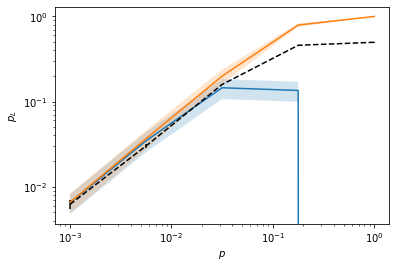

In [ ]:
#| slow

# Sampling parameters

sample_range = np.logspace(-3,0,5)
err_params = {'q': sample_range}
err_model = qs.noise.S1
CHP = qs.StabilizerSimulator
p_max = {'q': 1e-3}

# Direct MC sampling

print("--- Direct MC sampling ---")

mc_sam = qs.DirectSampler(ghz1, CHP, err_params=err_params, err_model=err_model)
mc_sam.run(10_000)

print("--- Subset sampling ---")

ss_sam = qs.SubsetSampler(protocol=ghz1, simulator=CHP,  p_max=p_max, err_model=err_model, err_params=err_params, L=1)
ss_sam.run(1_000)

# Plot results

p_L, std = mc_sam.stats()
p_L_low, ss_std_low, p_L_up, ss_std_up = ss_sam.stats()

plt.errorbar(sample_range, p_L, fmt='--', c="black", yerr=std, label="Direct MC")
plt.loglog(sample_range, p_L_low, label='SS low')
plt.fill_between(sample_range, p_L_low-ss_std_low, p_L_low+ss_std_low, alpha=0.2)
plt.loglog(sample_range, p_L_up, label='SS low')
plt.fill_between(sample_range, p_L_up-ss_std_up, p_L_up+ss_std_up, alpha=0.2)
plt.ylabel('$p_L$')
plt.xlabel('$p$')

## 2. Deterministic fault-tolerant preparation of Steane code state

See section 3C in paper

In [ ]:
#| export

eft = qs.Circuit([  {"init": {0,1,2,4,3,5,6,7}},
                    {"H": {0,1,3}},
                    {"CNOT": {(0,4)}},
                    {"CNOT": {(1,2)}},
                    {"CNOT": {(3,5)}},
                    {"CNOT": {(0,6)}},
                    {"CNOT": {(3,4)}},
                    {"CNOT": {(1,5)}},
                    {"CNOT": {(0,2)}},
                    {"CNOT": {(5,6)}},
                    {"CNOT": {(4,7)}},
                    {"CNOT": {(2,7)}},
                    {"CNOT": {(5,7)}},
                    {"measure": {7}} ])

sz_123 = qs.Circuit([   {"init": {8}},
                        {"CNOT": {(0,8)}},
                        {"CNOT": {(1,8)}},
                        {"CNOT": {(3,8)}},
                        {"CNOT": {(6,8)}},
                        {"measure": {8}}])

meas7 = qs.Circuit([ {"measure": {0,1,2,3,4,5,6}} ], noisy=True)

k1 = 0b0001111
k2 = 0b1010101
k3 = 0b0110011
k12 = k1 ^ k2
k23 = k2 ^ k3
k13 = k1 ^ k3
k123 = k12 ^ k3
stabilizerGenerators = [k1, k2, k3]
stabilizerSet = [0, k1, k2, k3, k12, k23, k13, k123]

def hamming2(x, y):
    count, z = 0, x ^ y
    while z:
        count += 1
        z &= z - 1
    return count


def logErr(out):
    import numpy as np
    c = np.array([hamming2(out, i) for i in stabilizerSet])
    d = np.flatnonzero(c <= 1)
    e = np.array([hamming2(out ^ (0b1111111), i) for i in stabilizerSet])
    f = np.flatnonzero(e <= 1)
    if len(d) != 0:
        return False
    elif len(f) != 0:
        return True
    if len(d) != 0 and len(f) != 0: 
        raise('-!-!-CANNOT BE TRUE-!-!-')

def flagged_z_look_up_table_1(z):
    s = [z]

    if s == [1]:
        return True
    else: 
        return False

functions = {"logErr": logErr, "lut": flagged_z_look_up_table_1}

steane0 = qs.Protocol(check_functions=functions, fault_tolerant=True)

steane0.add_nodes_from(['ENC', 'Z2', 'meas'], circuits=[eft, sz_123, meas7])
steane0.add_node('X_COR', circuit=qs.Circuit([{'X': {6}}], noisy=True))
steane0.add_edge('START', 'ENC', check='True')
steane0.add_edge('ENC', 'meas', check='ENC[-1]==0')
steane0.add_edge('ENC', 'Z2', check='ENC[-1]==1')
steane0.add_edge('Z2', 'X_COR', check='lut(Z2[-1])')
steane0.add_edge('Z2', 'meas', check='not lut(Z2[-1])')
steane0.add_edge('X_COR', 'meas', check='True')
steane0.add_edge('meas', 'FAIL', check='logErr(meas[-1])')

--- Direct MC sampling ---


p=('1.00e-04', '1.00e-03'):   0%|          | 0/10000 [00:00<?, ?it/s]

p=('3.16e-04', '3.16e-03'):   0%|          | 0/10000 [00:00<?, ?it/s]

p=('1.00e-03', '1.00e-02'):   0%|          | 0/10000 [00:00<?, ?it/s]

p=('3.16e-03', '3.16e-02'):   0%|          | 0/10000 [00:00<?, ?it/s]

p=('1.00e-02', '1.00e-01'):   0%|          | 0/10000 [00:00<?, ?it/s]

--- Subset sampling ---


p=('1.00e-03', '1.00e-02'):   0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 0, '$p$')

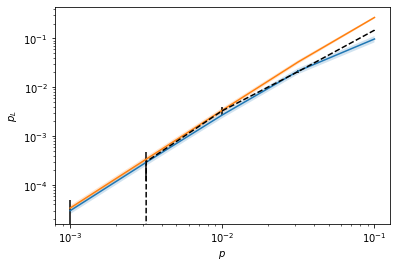

In [ ]:
#| slow

# Sampling parameters

sample_range = np.logspace(-3,-1,5)
err_params = {'q1': sample_range/10, 'q2': sample_range}
err_model = qs.noise.S2
CHP = qs.StabilizerSimulator
p_max = {'q1': 1e-3, 'q2': 1e-2}

# Direct MC sampling

print("--- Direct MC sampling ---")

mc_sam = qs.DirectSampler(steane0, CHP, err_params=err_params, err_model=err_model)
mc_sam.run(10_000)

print("--- Subset sampling ---")

ss_sam = qs.SubsetSampler(steane0, CHP,  p_max=p_max, err_model=err_model, err_params=err_params, L=4)
ss_sam.run(10_000)

# Plot results

p_L, std = mc_sam.stats()
p_L_low, ss_std_low, p_L_up, ss_std_up = ss_sam.stats()

plt.errorbar(sample_range, p_L, fmt='--', c="black", yerr=std, label="Direct MC")
plt.loglog(sample_range, p_L_low, label='SS low')
plt.fill_between(sample_range, p_L_low-ss_std_low, p_L_low+ss_std_low, alpha=0.2)
plt.loglog(sample_range, p_L_up, label='SS low')
plt.fill_between(sample_range, p_L_up-ss_std_up, p_L_up+ss_std_up, alpha=0.2)
plt.ylabel('$p_L$')
plt.xlabel('$p$')

## 3. Flag-FT stabilizer $|0\rangle_L$ measurement

See section 3D in paper

In [ ]:
#| export

fmx_1 = qs.Circuit([{"init": {8,9}},
                    {"H": {8}},
                    {"CNOT": {(8,3)}},
                    {"CNOT": {(8,9)}},
                    {"CNOT": {(8,4)}},
                    {"CNOT": {(8,5)}},
                    {"CNOT": {(8,9)}},
                    {"CNOT": {(8,6)}},
                    {"H": {8}},
                    {"measure": {8,9}}])

fmx_2 = qs.Circuit([{"init": {8,9}},
                    {"H": {8}},
                    {"CNOT": {(8,0)}},
                    {"CNOT": {(8,9)}},
                    {"CNOT": {(8,2)}},
                    {"CNOT": {(8,4)}},
                    {"CNOT": {(8,9)}},
                    {"CNOT": {(8,6)}},
                    {"H": {8}},
                    {"measure": {8,9}}])

fmx_3 = qs.Circuit([{"init": {8,9}},
                    {"H": {8}},
                    {"CNOT": {(8,1)}},
                    {"CNOT": {(8,9)}},
                    {"CNOT": {(8,2)}},
                    {"CNOT": {(8,5)}},
                    {"CNOT": {(8,9)}},
                    {"CNOT": {(8,6)}},
                    {"H": {8}},
                    {"measure": {8,9}}])

nfs = qs.Circuit([  {"init": {7,8,9}},
                    {"H": {7,8,9}},
                    {"CNOT": {(7,3)}},
                    {"CNOT": {(7,4)}},
                    {"CNOT": {(7,5)}},
                    {"CNOT": {(7,6)}},
                    {"CNOT": {(8,0)}},
                    {"CNOT": {(8,2)}},
                    {"CNOT": {(8,4)}},
                    {"CNOT": {(8,6)}},
                    {"CNOT": {(9,1)}},
                    {"CNOT": {(9,2)}},
                    {"CNOT": {(9,5)}},
                    {"CNOT": {(9,6)}},
                    {"H": {7,8,9}},
                    {"measure": {7,8,9}},
                    {"init": {7,8,9}},
                    {"CNOT": {(3,7)}},
                    {"CNOT": {(4,7)}},
                    {"CNOT": {(5,7)}},
                    {"CNOT": {(6,7)}},
                    {"CNOT": {(0,8)}},
                    {"CNOT": {(2,8)}},
                    {"CNOT": {(4,8)}},
                    {"CNOT": {(6,8)}},
                    {"CNOT": {(1,9)}},
                    {"CNOT": {(2,9)}},
                    {"CNOT": {(5,9)}},
                    {"CNOT": {(6,9)}},
                    {"measure": {7,8,9}} ])

# transitions

def flagged(m):
    v = [0b01] in m or [0b11] in m if m is not None else False
    return v

def flut(m, f1a, f1b, f2a, f2b, f3a, f3b):
    formatter = lambda i,m: str(format(m, '06b')[i])

    sx = ''.join([formatter(i,m) for i in range(3)])
    sz = ''.join([formatter(i,m) for i in range(3,6)])

    if (sz == '001' and flagged([f2a,f2b])) or (sz == '010' and (flagged([f1a,f1b]) or flagged([f3a,f3b]))):
        corrs = {'010': {5, 6}, '001': {4, 6}}
        return qs.Circuit([{'X': corrs[sz]}], noisy=False)
    else: 
        return qs.Circuit([{}], noisy=False)

def rep_check(m):
    # no flag triggered, run second round regardless of syndrome
    return m[-1] == 0b00 or m[-1] == 0b10

def nft_check1(m):
    # flag triggered in first or second round OR no flag triggered, syndromes disagree in second round
    return (m[-1] == 0b01 or m[-1] == 0b11 or (m[-1] == 0b01) or m[-1] == 0b11)

def nft_check2(m1,m2):
    return (m2[-1] == 0b00 and m1[-1] == 0b10) or (m2[-1] == 0b10 and m1[-1] == 0b00) or (m2[-1] == 0b01 or m2[-1] == 0b11)

def syn_check(m1,m2):
    # no flag triggered, syndromes agree in second round
    return (m2[-1] == 0b00 and m1[-1] == 0b00) or (m2[-1] == 0b10 and m1[-1] == 0b10)

functions = {"logErr": logErr, "flut": flut, "rep_check": rep_check, "nft_check1": nft_check1, 'nft_check2': nft_check2, "syn_check": syn_check}

# Define protocol

flagstab = qs.Protocol(check_functions=functions, fault_tolerant=True)
flagstab.add_nodes_from(['X1a', 'X1b', 'X2a', 'X2b', 'X3a', 'X3b', 'nonFT', 'meas'], circuits=[fmx_1, fmx_1, fmx_2,fmx_2, fmx_3,fmx_3, nfs, meas7])
flagstab.add_node('COR')
flagstab.add_edge('START', 'X1a', check='True')

# no flag triggered, run second round regardless of syndrome
flagstab.add_edge('X1a', 'X2a', check='rep_check(X1a)')
flagstab.add_edge('X2a', 'X3a', check='rep_check(X2a)')
flagstab.add_edge('X3a', 'X1b', check='rep_check(X3a)')

# flag triggered in first or second round OR no flag triggered, syndromes disagree in second round
flagstab.add_edge('X1b', 'nonFT', check='nft_check2(X1a,X1b)')
flagstab.add_edge('X2b', 'nonFT', check='nft_check2(X2a,X2b)')
flagstab.add_edge('X3b', 'nonFT', check='nft_check2(X3a,X3b)')

# flag triggered in first or second round OR no flag triggered, syndromes disagree in second round
flagstab.add_edge('X1a', 'nonFT', check='nft_check1(X1a)')
flagstab.add_edge('X2a', 'nonFT', check='nft_check1(X2a)')
flagstab.add_edge('X3a', 'nonFT', check='nft_check1(X3a)')

# no flag triggered, syndromes agree in second round
flagstab.add_edge('X1b', 'X2b', check='syn_check(X1a,X1b)')
flagstab.add_edge('X2b', 'X3b', check='syn_check(X2a,X2b)')
flagstab.add_edge('X3b', 'meas', check='syn_check(X3a,X3b)')

# apply flag correction after nonFT if a flag was triggered
flagstab.add_edge('nonFT', 'COR', check='flut(nonFT[-1], X1a,X1b, X2a,X2b, X3a,X3b)')
flagstab.add_edge('COR', 'meas', check='True')
flagstab.add_edge('meas', 'FAIL', check='logErr(meas[-1])')

--- Direct MC sampling ---


p=('1.00e-03',):   0%|          | 0/10000 [00:00<?, ?it/s]

p=('5.62e-03',):   0%|          | 0/10000 [00:00<?, ?it/s]

p=('3.16e-02',):   0%|          | 0/10000 [00:00<?, ?it/s]

p=('1.78e-01',):   0%|          | 0/10000 [00:00<?, ?it/s]

p=('1.00e+00',):   0%|          | 0/10000 [00:00<?, ?it/s]

--- Subset sampling ---


p=('1.00e-02',):   0%|          | 0/10000 [00:00<?, ?it/s]

Text(0.5, 0, '$p$')

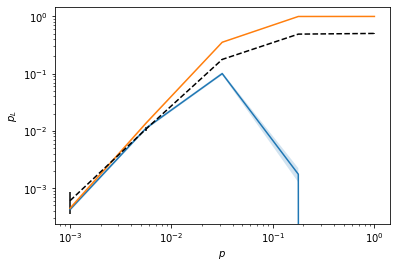

In [ ]:
#| slow

# Sampling parameters

sample_range = np.logspace(-3,0,5)
err_params = {'q': sample_range}
err_model = qs.noise.S1
CHP = qs.StabilizerSimulator
p_max = {'q': 1e-2}

# Direct MC sampling

print("--- Direct MC sampling ---")

mc_sam = qs.DirectSampler(flagstab, CHP, err_params=err_params, err_model=err_model)
mc_sam.run(10_000)

print("--- Subset sampling ---")

ss_sam = qs.SubsetSampler(flagstab, CHP,  p_max=p_max, err_model=err_model, err_params=err_params, L=8)
ss_sam.run(10_000)

# Plot results

p_L, std = mc_sam.stats()
p_L_low, ss_std_low, p_L_up, ss_std_up = ss_sam.stats()

plt.errorbar(sample_range, p_L, fmt='--', c="black", yerr=std, label="Direct MC")
plt.loglog(sample_range, p_L_low, label='SS low')
plt.fill_between(sample_range, p_L_low-ss_std_low, p_L_low+ss_std_low, alpha=0.2)
plt.loglog(sample_range, p_L_up, label='SS low')
plt.fill_between(sample_range, p_L_up-ss_std_up, p_L_up+ss_std_up, alpha=0.2)
plt.ylabel('$p_L$')
plt.xlabel('$p$')